# 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [98]:

import json
import math
from typing import List, Optional
!pip install parsel
!pip install scrapfly-sdk
from parsel import Selector
from typing_extensions import TypedDict
from scrapfly import ScrapflyClient, ScrapeConfig

import re
import pandas as pd
from bs4 import BeautifulSoup
from scrapfly import ScrapflyClient, ScrapeConfig




client = ScrapflyClient("scp-live-e845369bb67a4b8298658e087cb182e5")

def find_properties(state: str, city: str, pages: int = 30):
    house_info_list = []
    for page in range(1, pages + 1):
        print(f"Scraping page {page} for {city}, {state}")
        page_url = f"https://www.realtor.com/realestateandhomes-search/{city}_{state.upper()}/pg-{page}"

        scrape_result = client.scrape(ScrapeConfig(url=page_url, country="US", asp=True))
        html_content = scrape_result.content

        soup = BeautifulSoup(html_content, 'html.parser')
        properties_info = soup.find_all('li', attrs={'data-testid': re.compile(r'property-meta-.+')})
        properties_set = set([info.find_parent('ul') for info in properties_info])


        for prop in properties_set:
            if prop:
                beds = prop.find('li', {'data-testid': 'property-meta-beds'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-beds'}) else 'N/A'
                baths = prop.find('li', {'data-testid': 'property-meta-baths'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-baths'}) else 'N/A'
                sqft = prop.find('li', {'data-testid': 'property-meta-sqft'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-sqft'}) else 'N/A'
                lot_size = prop.find('li', {'data-testid': 'property-meta-lot-size'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-lot-size'}) else 'N/A'

                price_wrapper = prop.find_previous_sibling('div', class_='price-wrapper')
                price = price_wrapper.find('div', {'data-testid': 'card-price'}).get_text(strip=True) if price_wrapper else 'N/A'

                house_info = {
                    'Price': price,
                    'Beds': beds,
                    'Baths': baths,
                    'Area (sqft)': sqft,
                    'Lot Size': lot_size
                }

                house_info_list.append(house_info)

    return house_info_list




In [99]:

locations = [
    ("Los-Angeles","CA"),
    ("San-Francisco", "CA"),
    ("New-York", "NY"),
    ("Seattle", "WA"),
    ("Dallas", "TX")
]

dfs = {}

for city, state in locations:
    house_info_list = find_properties(state, city, 30)
    dfs[city] = pd.DataFrame(house_info_list)

print(dfs["San-Francisco"])


Scraping page 1 for Los-Angeles, CA
Scraping page 2 for Los-Angeles, CA
Scraping page 3 for Los-Angeles, CA
Scraping page 4 for Los-Angeles, CA
Scraping page 5 for Los-Angeles, CA
Scraping page 6 for Los-Angeles, CA
Scraping page 7 for Los-Angeles, CA
Scraping page 8 for Los-Angeles, CA
Scraping page 9 for Los-Angeles, CA
Scraping page 10 for Los-Angeles, CA
Scraping page 11 for Los-Angeles, CA
Scraping page 12 for Los-Angeles, CA
Scraping page 13 for Los-Angeles, CA
Scraping page 14 for Los-Angeles, CA
Scraping page 15 for Los-Angeles, CA
Scraping page 16 for Los-Angeles, CA
Scraping page 17 for Los-Angeles, CA
Scraping page 18 for Los-Angeles, CA
Scraping page 19 for Los-Angeles, CA
Scraping page 20 for Los-Angeles, CA
Scraping page 21 for Los-Angeles, CA
Scraping page 22 for Los-Angeles, CA
Scraping page 23 for Los-Angeles, CA
Scraping page 24 for Los-Angeles, CA
Scraping page 25 for Los-Angeles, CA
Scraping page 26 for Los-Angeles, CA
Scraping page 27 for Los-Angeles, CA
Scraping p

In [100]:
import pandas as pd

for city, df in dfs.items():
    df['City'] = city

all_cities_df = pd.concat(dfs.values(), ignore_index=True)
all_cities_df.head()



,Price,Beds,Baths,Area (sqft),Lot Size,City
0,"$195,000,000",7,20,N/A,8.4,Los-Angeles
1,"$126,000,000",8,20,"30,610",9.9,Los-Angeles
2,"$9,500,000",5,7,"9,375",0.74,Los-Angeles
3,"$1,899,000",2,2.5,"1,731","8,371",Los-Angeles
4,"$97,500",2,2,"1,080",N/A,Los-Angeles


In [101]:
import pandas as pd
import requests
import requests_cache
from bs4 import BeautifulSoup
import re

def scrape_city_data(locations):
    base_url = "https://www.city-data.com/"

    results = []

    for city, state in locations:
        path = f'/city/{city.replace(" ", "-")}-{state.replace(" ", "-")}.html'

        response = requests.get(base_url + path)
        response.raise_for_status()  
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        cost_of_living_section = soup.find('section', id='cost-of-living-index')
        median_income_section = soup.find('section', id='median-income')
        crime_section = soup.find('section', id='crime')

        city_data = {"City": city, "State": state}

        if cost_of_living_section:
            cost_of_living_text = cost_of_living_section.get_text()
            index_value = cost_of_living_text.split(':')[1].split()[0]
            city_data["Cost of Living Index"] = index_value

        if median_income_section:
            income_text = median_income_section.get_text()
            income_value = income_text.split(':')[1].split()[0]
            income_value = re.sub(r'[^\d.]', '', income_value)  
            city_data["Median Income"] = income_value

        if crime_section:
            headers = crime_section.find('thead').find('tr').find_all('th')
            
            index_2020 = None
            for i, header in enumerate(headers):
                if header.get_text().strip() == "2020":
                    index_2020 = i
                    break
            
            if index_2020 is not None:
                crime_index_row = crime_section.find('tfoot').find('tr').find_all('td')
                crime_index_2020 = crime_index_row[index_2020].get_text()
                city_data["Crime Index "] = crime_index_2020

        results.append(city_data)

    return results

locations = [
    ("Los-Angeles", "California"),
    ("San-Francisco", "California"),
    ("New-York", "New York"),
    ("Seattle", "Washington"),
    ("Dallas", "Texas")
]


city_data = scrape_city_data(locations)

df = pd.DataFrame(city_data)

df.head()

,City,State,Cost of Living Index,Median Income,Crime Index
0,Los-Angeles,California,145.1,70372,327.4
1,San-Francisco,California,141.1,121826,387.4
2,New-York,New York,160.2,67997,229.7
3,Seattle,Washington,118.5,110781,440.8
4,Dallas,Texas,96.1,57995,439.5


### We scraped through https://www.city-data.com/ to get the cost of living index, median income, and crime index of all of the cities we were interested in to see if this will make an impact on the house price per city. ###

In [102]:
merged_df = pd.merge(df, all_cities_df, on='City')
merged_df.head()


merged_df.to_csv('real_estate_data.csv', index=False)
print("The merged DataFrame has been saved to real_estate_data.csv.")


The merged DataFrame has been saved to real_estate_data.csv.


# 2

https://api.developer.attomdata.com/docs#!/Valuation32V1/assessmentHistoryDetailID

In [103]:


url ="https://api.gateway.attomdata.com/propertyapi/v1.0.0/property/id?geoid=PL0820000&minBeds=1"
headers = {
    "accept": "application/json",
    "apikey": "37b77047fa1778ca3c56c8871e08a387"
}
response = requests.get(url, headers=headers)
json_data=response.json()

ids = [property["identifier"]["Id"] for property in json_data["property"]]

ids

[143367,
 143382,
 143899,
 144393,
 144394,
 145233,
 145234,
 145235,
 146764,
 147146]

In [104]:

for attomId in ids:
    url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/assessmenthistory/detail"
    params = {"attomId": attomId}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        json_data = response.json()
        assessment_history = json_data['property'][0]['assessmenthistory']

        historical_prices = []
        for history in assessment_history:
            assessed_info = {
                'year': history.get('tax', {}).get('assessorYear'),
                'assessed_improvement_value': history.get('assessed', {}).get('assdImprValue'),
                'assessed_land_value': history.get('assessed', {}).get('assdLandValue'),
                'total_assessed_value': history.get('assessed', {}).get('assdTtlValue'),
                'market_improvement_value': history.get('market', {}).get('mktImprValue'),
                'market_land_value': history.get('market', {}).get('mktLandValue'),
                'total_market_value': history.get('market', {}).get('mktTtlValue'),
                'tax_amount': history.get('tax', {}).get('taxAmt'),
            }
            historical_prices.append(assessed_info)

        df = pd.DataFrame(historical_prices)
        csv_file_path = f'attomId_{attomId}_historical_prices.csv'
        df.to_csv(csv_file_path, index=False)
    else:
        print(f"Error fetching historical information for attomId {attomId}: {response.status_code}")

# 3

In [105]:

import pandas as pd
import numpy as np

# Load the dataset
file_path = 'real_estate_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and content
data.tail(50)


,City,State,Cost of Living Index,Median Income,Crime Index,Price,Beds,Baths,Area (sqft),Lot Size
1144,Dallas,Texas,96.1,57995,439.5,"$1,009,000",4,3,"3,445",0.23
1145,Dallas,Texas,96.1,57995,439.5,"$3,650,000",3,3.5+,"4,652",0.76
1146,Dallas,Texas,96.1,57995,439.5,"$995,000",3,3.5,"3,157",0.26
1147,Dallas,Texas,96.1,57995,439.5,"$120,000",2,1,"1,134","8,451"
1148,Dallas,Texas,96.1,57995,439.5,"$749,900",3,2,"1,718","9,365"
1149,Dallas,Texas,96.1,57995,439.5,"$1,625,000",3,3,"3,779","7,405"
1150,Dallas,Texas,96.1,57995,439.5,"$525,000",3,2,"1,880","7,841"
1151,Dallas,Texas,96.1,57995,439.5,"$350,000",2,1.5,"1,095",0.57
1152,Dallas,Texas,96.1,57995,439.5,"$795,000",4,3,"2,868","9,888"
1153,Dallas,Texas,96.1,57995,439.5,"$749,000",4,2.5,"2,758","8,276"


In [106]:

# Remove currency symbols and commas from 'Price', then convert to numeric
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Beds', 'Baths', and 'Lot Size' to numeric, handling missing values as NaN
columns_to_numeric = ['Beds', 'Baths', 'Lot Size']
data[columns_to_numeric] = data[columns_to_numeric].replace('None', np.nan).apply(pd.to_numeric, errors='coerce')

# Remove commas from 'Area (sqft)' and convert to numeric
data['Area (sqft)'] = data['Area (sqft)'].str.replace(',', '').astype(float)

# Re-check the cleaned data
cleaned_data_info = data.info()
cleaned_data_head = data.head()

cleaned_data_info, cleaned_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  1194 non-null   object 
 1   State                 1194 non-null   object 
 2   Cost of Living Index  1194 non-null   float64
 3   Median Income         1194 non-null   int64  
 4   Crime Index           1194 non-null   float64
 5   Price                 1194 non-null   float64
 6   Beds                  1094 non-null   float64
 7   Baths                 1047 non-null   float64
 8   Area (sqft)           1053 non-null   float64
 9   Lot Size              310 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 93.4+ KB


(None,
           City       State  Cost of Living Index  Median Income  Crime Index   \
 0  Los-Angeles  California                 145.1          70372         327.4   
 1  Los-Angeles  California                 145.1          70372         327.4   
 2  Los-Angeles  California                 145.1          70372         327.4   
 3  Los-Angeles  California                 145.1          70372         327.4   
 4  Los-Angeles  California                 145.1          70372         327.4   
 
          Price  Beds  Baths  Area (sqft)  Lot Size  
 0  195000000.0   7.0   20.0          NaN      8.40  
 1  126000000.0   8.0   20.0      30610.0      9.90  
 2    9500000.0   5.0    7.0       9375.0      0.74  
 3    1899000.0   2.0    2.5       1731.0       NaN  
 4      97500.0   2.0    2.0       1080.0       NaN  )

In [107]:

data_cleaned = data.dropna()

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()

data_cleaned_info, data_cleaned_head


<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 1 to 1191
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  241 non-null    object 
 1   State                 241 non-null    object 
 2   Cost of Living Index  241 non-null    float64
 3   Median Income         241 non-null    int64  
 4   Crime Index           241 non-null    float64
 5   Price                 241 non-null    float64
 6   Beds                  241 non-null    float64
 7   Baths                 241 non-null    float64
 8   Area (sqft)           241 non-null    float64
 9   Lot Size              241 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 20.7+ KB


(None,
            City       State  Cost of Living Index  Median Income  \
 1   Los-Angeles  California                 145.1          70372   
 2   Los-Angeles  California                 145.1          70372   
 5   Los-Angeles  California                 145.1          70372   
 9   Los-Angeles  California                 145.1          70372   
 12  Los-Angeles  California                 145.1          70372   
 
     Crime Index         Price  Beds  Baths  Area (sqft)  Lot Size  
 1          327.4  126000000.0   8.0   20.0      30610.0      9.90  
 2          327.4    9500000.0   5.0    7.0       9375.0      0.74  
 5          327.4    2595000.0   3.0    3.5       2814.0      0.26  
 9          327.4     999900.0   4.0    3.5       2256.0      0.52  
 12         327.4   88000000.0  10.0   22.0      24757.0     19.75  )

In [108]:
# Calculate price per square foot
data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']

# Display the first few rows of the data with the calculated price per square foot
data_cleaned[['Price', 'Area (sqft)', 'Price_per_sqft']].head()


/var/folders/lx/4_g1bf5951j3ls64g8b047yr0000gn/T/ipykernel_45821/1802613730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']


,Price,Area (sqft),Price_per_sqft
1,126000000.0,30610.0,4116.301862
2,9500000.0,9375.0,1013.333333
5,2595000.0,2814.0,922.174840
9,999900.0,2256.0,443.218085
12,88000000.0,24757.0,3554.550228


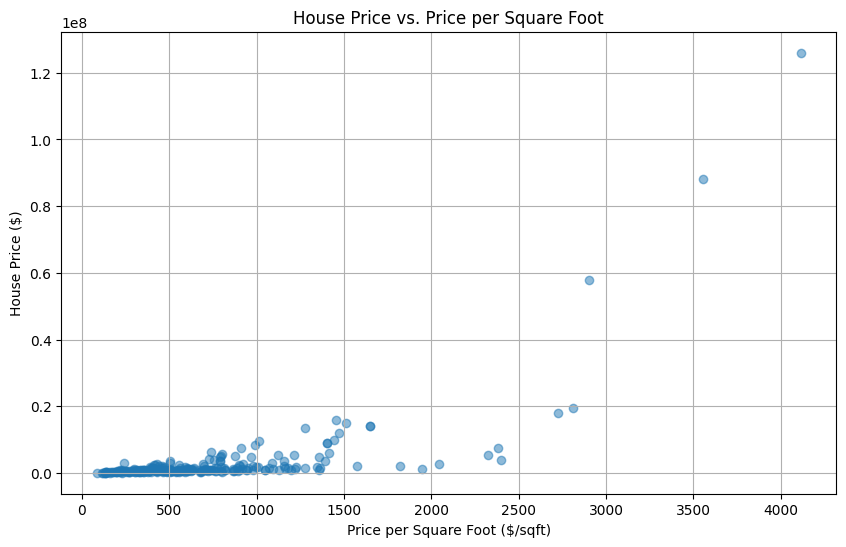

In [109]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Price_per_sqft'], data_cleaned['Price'], alpha=0.5)
plt.title('House Price vs. Price per Square Foot')
plt.xlabel('Price per Square Foot ($/sqft)')
plt.ylabel('House Price ($)')
plt.grid(True)
plt.show()


/var/folders/lx/4_g1bf5951j3ls64g8b047yr0000gn/T/ipykernel_45821/1675166368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']


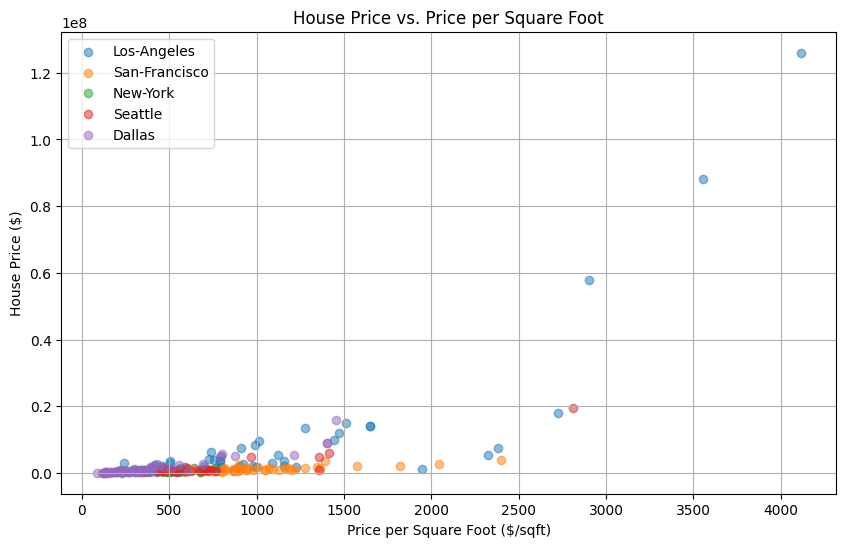

In [110]:
import matplotlib.pyplot as plt

# Calculate price per square foot considering the city
data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']

# Create a scatter plot with different colors for each city
plt.figure(figsize=(10, 6))
for city in data_cleaned['City'].unique():
    city_data = data_cleaned[data_cleaned['City'] == city]
    plt.scatter(city_data['Price_per_sqft'], city_data['Price'], alpha=0.5, label=city)

plt.title('House Price vs. Price per Square Foot')
plt.xlabel('Price per Square Foot ($/sqft)')
plt.ylabel('House Price ($)')
plt.legend()
plt.grid(True)
plt.show()


Linear Regression Train RMSE: 4303695.792114713
Linear Regression Test RMSE: 4115533.251607956
Multiple Linear Regression Train RMSE: 4303695.792114713
Multiple Linear Regression Test RMSE: 4115533.251607956


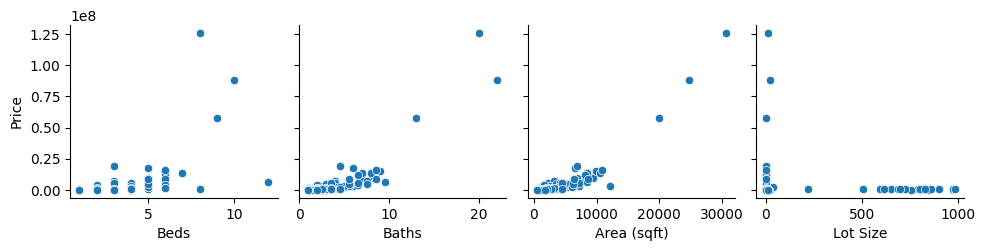

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Select relevant features (factors) and target variable (price)
X = data_cleaned[['Beds', 'Baths', 'Area (sqft)', 'Lot Size']]
y = data_cleaned['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Train multiple linear regression model
multiple_linear_reg_model = LinearRegression()
multiple_linear_reg_model.fit(X_train, y_train)

# Evaluate the models
linear_reg_train_rmse = mean_squared_error(y_train, linear_reg_model.predict(X_train), squared=False)
linear_reg_test_rmse = mean_squared_error(y_test, linear_reg_model.predict(X_test), squared=False)

multiple_linear_reg_train_rmse = mean_squared_error(y_train, multiple_linear_reg_model.predict(X_train), squared=False)
multiple_linear_reg_test_rmse = mean_squared_error(y_test, multiple_linear_reg_model.predict(X_test), squared=False)

# Display the root mean squared error (RMSE) for both models
print("Linear Regression Train RMSE:", linear_reg_train_rmse)
print("Linear Regression Test RMSE:", linear_reg_test_rmse)
print("Multiple Linear Regression Train RMSE:", multiple_linear_reg_train_rmse)
print("Multiple Linear Regression Test RMSE:", multiple_linear_reg_test_rmse)

# Visualize the relationships between factors and price using pairplot
sns.pairplot(data_cleaned, x_vars=['Beds', 'Baths', 'Area (sqft)', 'Lot Size'], y_vars=['Price'])
plt.show()


In [112]:
import pandas as pd

file_path = "attomId_147146_historical_prices.csv"
data = pd.read_csv(file_path)

print(data.head())


   year  assessed_improvement_value  assessed_land_value  \
0  2015                       12620                 1740   
1  2014                        8110                 1990   
2  2013                        8110                 1990   
3  2011                        8651                 2189   
4  2022                       21640                 3950   

   total_assessed_value  market_improvement_value  market_land_value  \
0                 14360                  158500.0            21900.0   
1                 10100                  101900.0            25000.0   
2                 10100                  101900.0            25000.0   
3                 10840                       NaN                NaN   
4                 25590                  311400.0            56900.0   

   total_market_value  tax_amount  
0              180400     1490.95  
1              126900     1167.10  
2              126900     1167.46  
3              136200     1125.27  
4              368300     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

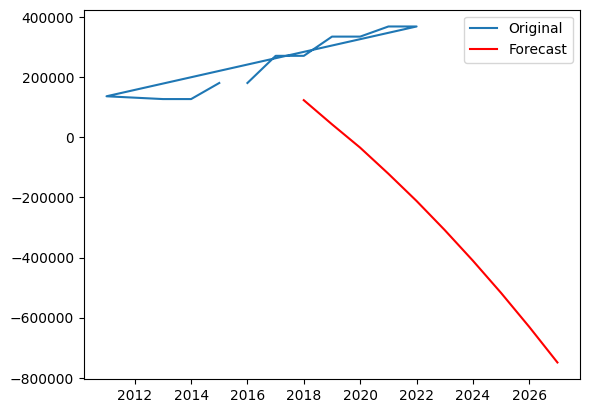

In [113]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

file_path = "attomId_147146_historical_prices.csv"
data = pd.read_csv(file_path)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data.set_index('year', inplace=True)

model = ARIMA(data['total_market_value'], order=(1,3,1)) # 这里是一个示例，你可以根据需要调整参数
results = model.fit()

forecast = results.forecast(steps=10) # 假设你想预测未来10个时间点的值

plt.plot(data.index, data['total_market_value'], label='Original')
plt.plot(pd.date_range(start=data.index[-1], periods=11, freq='Y')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.show()